### Prepare venv

#### const parameters

In [151]:
dir = "../dataset/variance256_aug/"
out = "../results/shap/"
labels = ["canter", "trot", "walk"]

rng = 42

batch_size  = 8
epochs      = 10

#### imports

In [152]:
# from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import os
import shap

# from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim


#### load variances

In [153]:
files = sorted(os.listdir(dir))

X_list, y_list = [], []

for label in labels:
    for file in sorted(os.listdir(dir + label)):
        var = np.load(dir + label + "/" + file).astype(np.float32)
        X_list.append(var)
        y_list.append(labels.index(label))

X = np.stack(X_list, axis=0)       # shape: (N, 256, 256)
y = np.array(y_list)               # shape: (N,)

X = X[..., np.newaxis]

### Models

In [3]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Input: 1x256x256 → Output: 16x256x256
            nn.ReLU(),
            nn.MaxPool2d(2),                             # Output: 16x128x128

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # Output: 32x128x128
            nn.ReLU(),
            nn.MaxPool2d(2),                             # Output: 32x64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: 64x64x64
            nn.ReLU(),
            nn.MaxPool2d(2),                             # Output: 64x32x32
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1,1,256,256)
            n_features = self._num_flat_features(dummy)
        
        self.fc = nn.Linear(n_features, 3)

    def _num_flat_features(self, x):
        x = self.conv(x)
        return x.numel() // x.size(0)
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [66]:
best = SmallCNN()
best.load_state_dict(torch.load("../results/models/cnn/5.pth"))
best.eval()

C:\Users\1310i\AppData\Local\Temp\ipykernel_47712\2462751078.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best.load_state_dict(torch.load("../results/models/cnn/5.pth

SmallCNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=65536, out_features=3, bias=True)
)

# define explainer

In [169]:
start=100

In [170]:
# def predict(x):
#     # x comes from SHAP as numpy, shape: (N, H, W, C)
#     x = torch.from_numpy(x).float()
#     x = x.permute(0, 3, 1, 2)  # NHWC → NCHW

#     with torch.no_grad():
#         y = best(x)

#     return y.cpu().numpy()

def predict(X):
    X_tensor = torch.from_numpy(X).float()         # convert to float
    X_tensor = X_tensor.permute(0,3,1,2)          # NHWC -> NCHW
    best.eval()
    with torch.no_grad():
        out = best(X_tensor)
        probs = torch.softmax(out, dim=1).cpu().numpy()
    return probs

masker = shap.maskers.Image(
    "inpaint_telea", 
    shape=(256,256,1))
explainer = shap.Explainer(predict, masker, output_names=labels)

shap_values = explainer(
    X[start:start+5], max_evals=100
)

PartitionExplainer explainer: 6it [00:11, 11.72s/it]               


In [171]:
def plot_overlayed(i, img, shap_val):
    # Normalize grayscale image to 0..1 for imshow
    img_norm = (img - img.min()) / (img.max() - img.min())

    # Normalize SHAP values for color overlay
    shap_norm = shap_val.copy()
    shap_norm -= shap_norm.min()    # shift min to 0
    if shap_norm.max() > 0:
        shap_norm /= shap_norm.max()  # scale to 0..1
        

    # Plot
    plt.figure(figsize=(6,6))
    plt.imshow(img_norm, cmap='gray')
    plt.imshow(shap_norm, cmap='BuPu', alpha=0.5)  # overlay SHAP
    plt.title(f"Predicted: {labels[np.argmax(predict(img[np.newaxis, ..., np.newaxis]))]}")


    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label("SHAP value", rotation=270, labelpad=15)

    plt.axis('off')
    plt.show()
    

In [ ]:
def plot_besides(i, img, shap_val):

    # Normalize grayscale for display
    img_norm = (img - img.min()) / (img.max() - img.min())

    # For SHAP overlay, keep original scale with center=0
    vmax = np.max(np.abs(shap_val))
    
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    
    # get labels
    img_input = img[np.newaxis, ..., np.newaxis]  # shape (1,H,W,1)
    pred = predict(img_input)[0]                  # shape (3,)
    
    og_label = labels[np.argmax(pred)]
    
    # Original image
    axes[0].imshow(img_norm, cmap='gray')
    axes[0].set_title("Variance map"  + (f"\nLabel: {og_label}"))
    axes[0].axis('off')

    # SHAP overlay
    im = axes[1].imshow(img_norm, cmap='gray', alpha=0.8)  # base image
    im2 = axes[1].imshow(shap_val, cmap='seismic', alpha=0.6, vmin=-vmax, vmax=vmax)
    axes[1].set_title("SHAP Overlay" + (f"\nPredicted: {labels[np.argmax(pred)]}"))
    axes[1].axis('off')

    # Shared colorbar for SHAP
    cbar = fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_label("SHAP value", rotation=270, labelpad=15)

    plt.show()


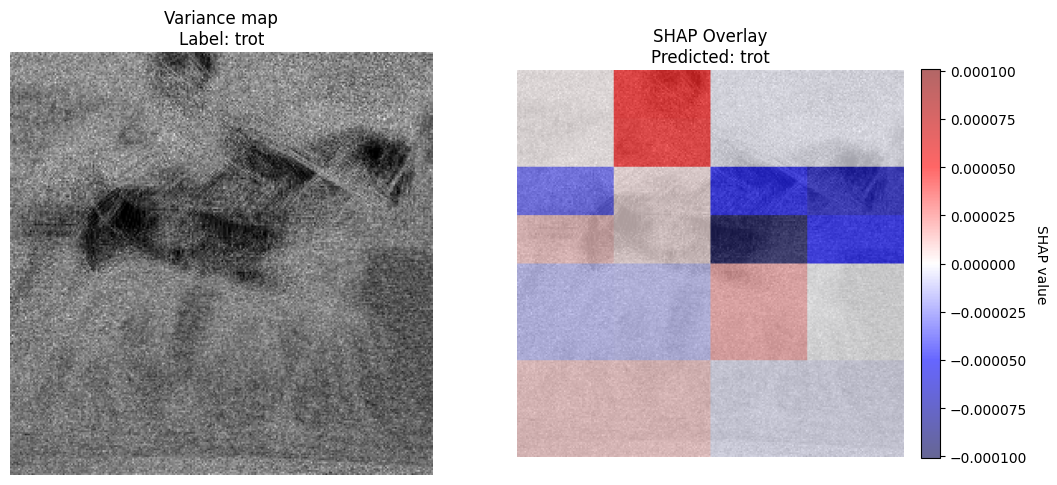

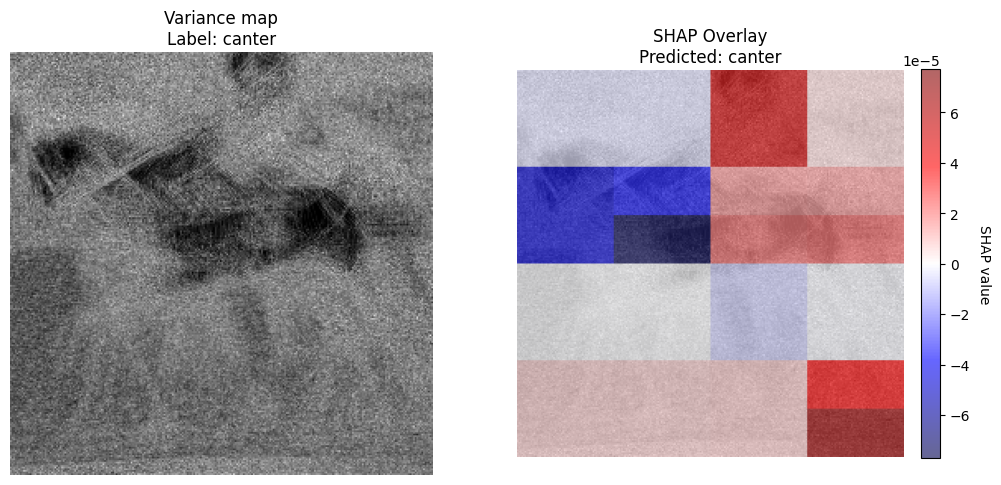

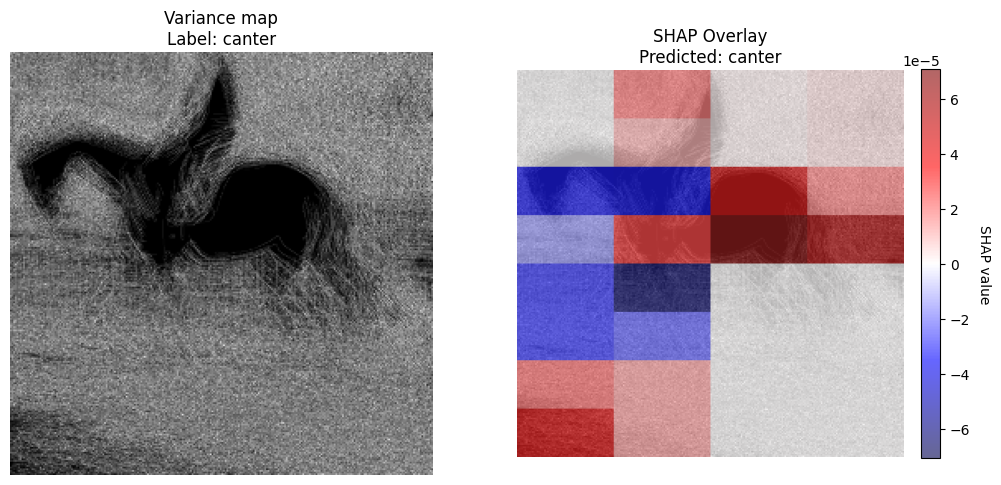

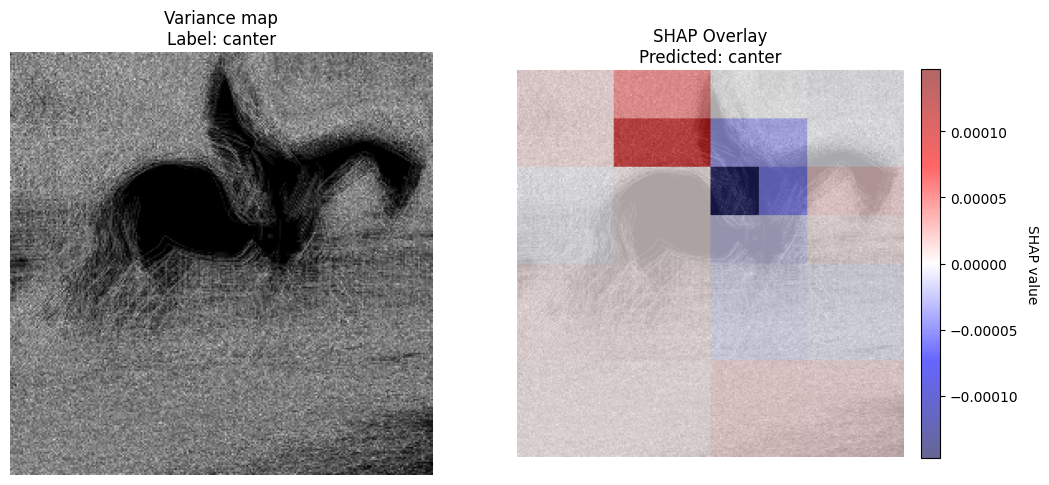

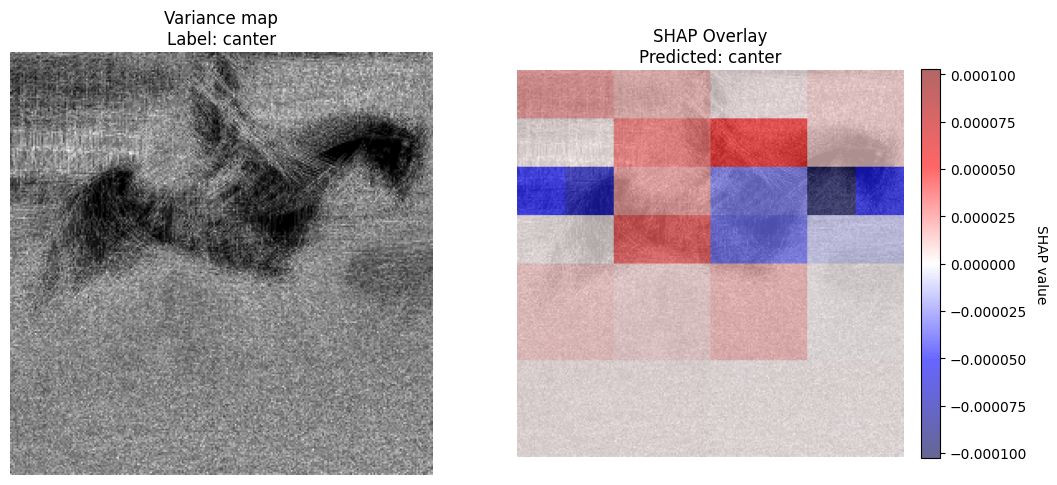

In [196]:
for i in range(len(shap_values.values)):
    img = X[i+start][...,0]          # (256,256)
    shap_val = shap_values.values[i][...,0]  # same shape
    #plot_overlayed(i, img, shap_val)
    plot_besides(i, img, shap_val)

# mean SHAP

In [213]:
# plot per class
def plot_per_class(class_name, shap_val):
    # For SHAP overlay, keep original scale with center=0
    vmax = np.max(np.abs(shap_val))
    
    fig, axes = plt.subplots(1, 1, figsize=(12,6))

    # SHAP overlay
    im2 = axes.imshow(shap_val, cmap='seismic', alpha=0.6, vmin=-vmax, vmax=vmax)
    axes.axis('off')
    # Shared colorbar for SHAP
    cbar = fig.colorbar(im2, ax=axes, fraction=0.046, pad=0.04)
    cbar.set_label("SHAP value", rotation=270, labelpad=15)
    
    # Add class label as suptitle
    plt.suptitle(f"Class: {class_name}", fontsize=16)

    plt.show()

In [215]:
# indexes of classes
canter = 0
trot = 804
walk = 1640

# subset for SHAP
sub_X = np.concatenate([
    X[canter:canter+100],
    X[trot:trot+100],
    X[walk:walk+100]
], axis=0)
sub_y = np.concatenate([
    y[canter:canter+100],
    y[trot:trot+100],
    y[walk:walk+100]
], axis=0)

shap_values_subset = explainer(sub_X, max_evals=100)


PartitionExplainer explainer: 301it [15:24,  3.11s/it]                         


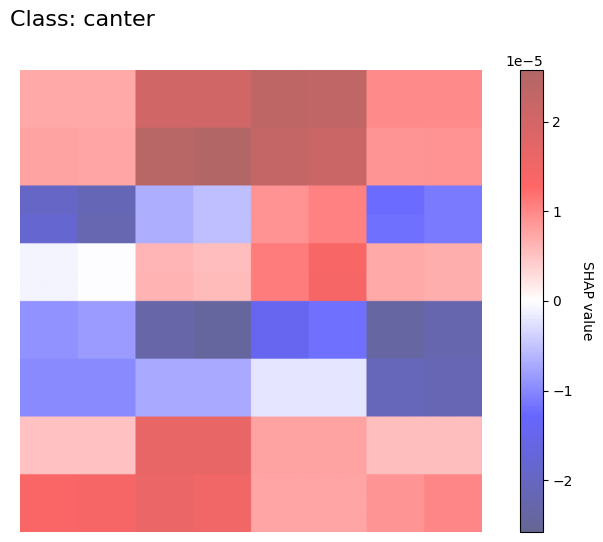

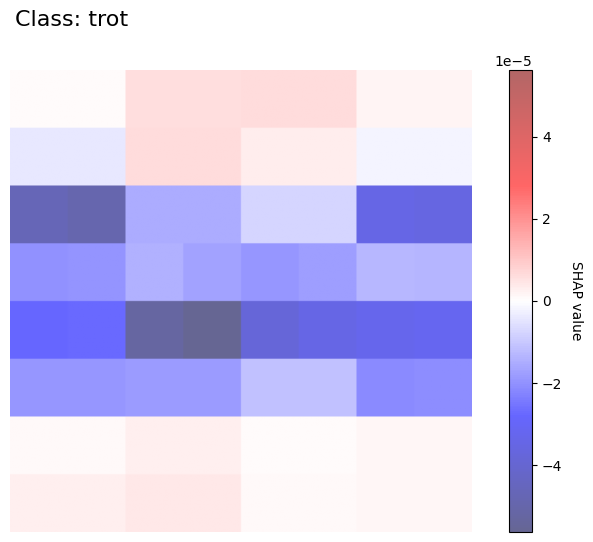

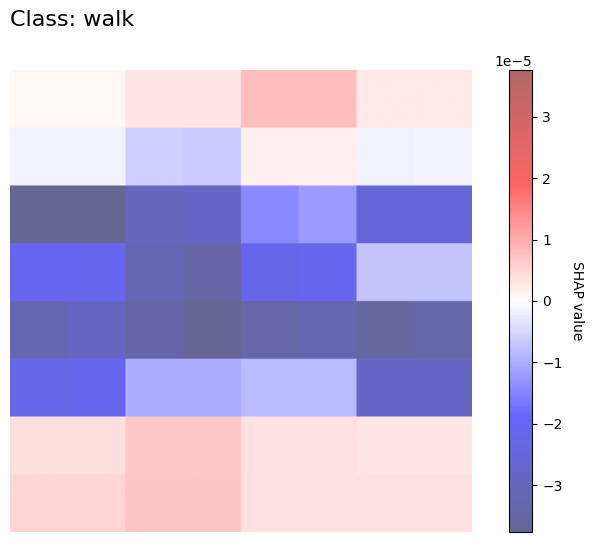

In [216]:
# mean SHAP per class
for class_idx, class_name in enumerate(labels):
    class_shap = shap_values_subset.values[sub_y == class_idx]  # shape (10, 256, 256, 1)
    mean_shap = np.mean(class_shap, axis=0)  # shape (256, 256, 1)
    plot_per_class(class_name, mean_shap[...,0])